In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import arviz as az
import requests
from io import StringIO
from scipy.stats import gaussian_kde
import warnings
plt.rcParams["figure.constrained_layout.use"] = True

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
# Define the URL of the CSV file on GitHub
url = "https://raw.githubusercontent.com/boboppie/kruschke-doing_bayesian_data_analysis/master/2e/TherapeuticTouchData.csv"
# Download the content of the CSV file
response = requests.get(url)
tt_dat = pd.read_csv(StringIO(response.text))
print(tt_dat.head())

   y    s
0  1  S01
1  0  S01
2  0  S01
3  0  S01
4  0  S01


In [4]:
tt_dat.shape

(280, 2)

In [5]:
tt_agg = tt_dat.groupby("s").agg(proportion_correct=("y", "mean")).reset_index()
tt_agg

,s,proportion_correct
0,S01,0.1
1,S02,0.2
2,S03,0.3
3,S04,0.3
4,S05,0.3
5,S06,0.3
6,S07,0.3
7,S08,0.3
8,S09,0.3
9,S10,0.3


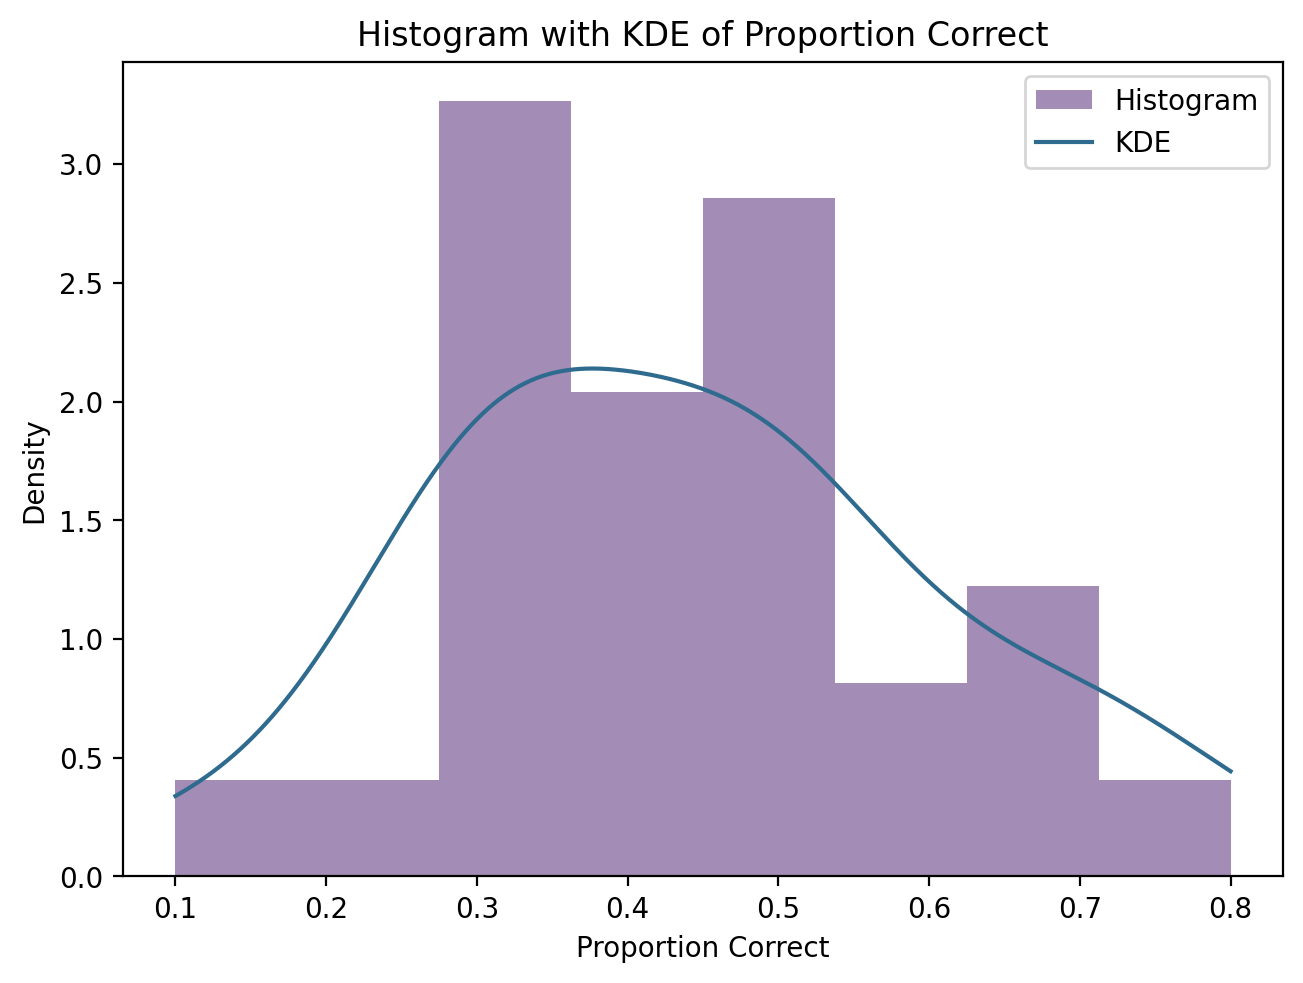

In [6]:
# Create the histogram
plt.hist(tt_agg.proportion_correct, bins=8, density=True, alpha=0.5, label="Histogram")

# KDE plot
kde = gaussian_kde(tt_agg.proportion_correct)
x_range = np.linspace(
    min(tt_agg.proportion_correct), max(tt_agg.proportion_correct), 1000
)
plt.plot(x_range, kde(x_range), label="KDE")

plt.xlabel("Proportion Correct")
plt.ylabel("Density")
plt.title("Histogram with KDE of Proportion Correct")
plt.legend()
plt.show()

In [7]:
result = tt_dat.groupby("s")["y"].sum().reset_index()
y = result["y"]
print(*y)

1 2 3 3 3 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 5 5 6 6 7 7 7 8


In [8]:
y.mean()

4.392857142857143

In [9]:
N = tt_dat.groupby("s")["y"].count() 
N

s
S01    10
S02    10
S03    10
S04    10
S05    10
S06    10
S07    10
S08    10
S09    10
S10    10
S11    10
S12    10
S13    10
S14    10
S15    10
S16    10
S17    10
S18    10
S19    10
S20    10
S21    10
S22    10
S23    10
S24    10
S25    10
S26    10
S27    10
S28    10
Name: y, dtype: int64

In [10]:
print(*N)

10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10


In [11]:
print(*y)

1 2 3 3 3 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 5 5 6 6 7 7 7 8


In [12]:
# The data has one dimension: operators_idx
# The "coordinates" are the unique values that this dimension can take
COORDS = {
    "operators_idx": np.arange(len(y)),
}

print(COORDS)

{'operators_idx': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])}


In [13]:
with pm.Model(coords=COORDS) as model:
    y_data = pm.ConstantData("y_data", y)
    n_trials = pm.ConstantData("n_trials", N)
    alpha = pm.Gamma("alpha", 8, 2)
    beta = pm.Gamma("beta", 27, 5)
    p = pm.Beta("p", alpha, beta, dims="operators_idx")
    Y_obs = pm.Binomial("Y_obs", n=n_trials, p=p, observed=y_data, dims="operators_idx")

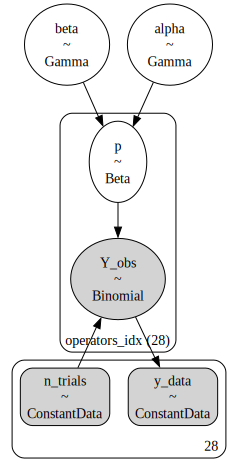

In [14]:
pm.model_to_graphviz(model)

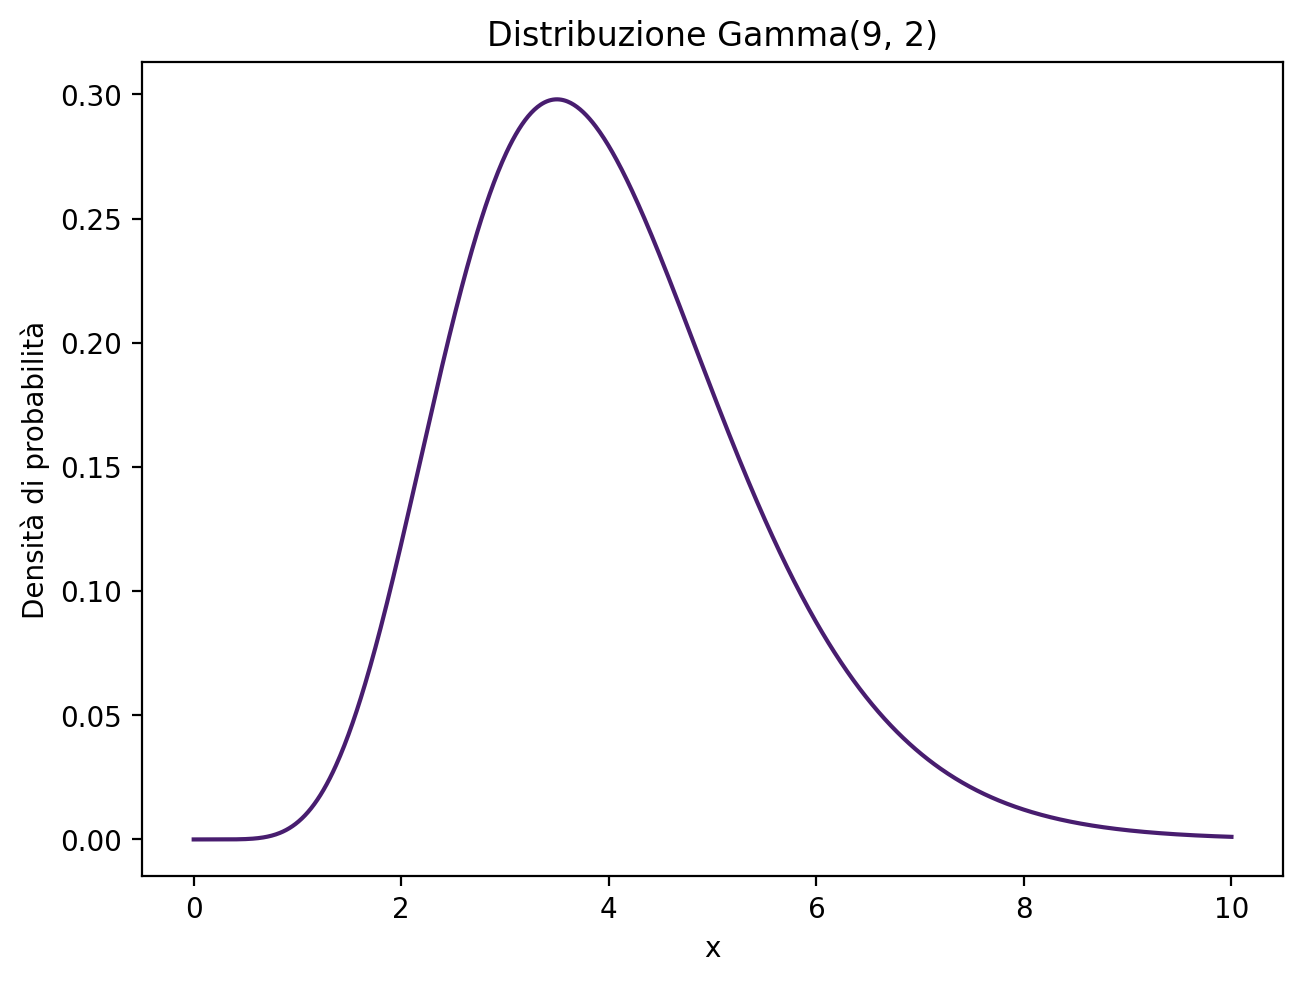

In [15]:
a = 8
b = 2

x = np.linspace(0, 10, 1000)  # Valori x da 0 a 10
yy = stats.gamma.pdf(x, a, scale=1/b)  # Funzione di densità di probabilità Gamma

plt.plot(x, yy)
plt.xlabel('x')
plt.ylabel('Densità di probabilità')
plt.title('Distribuzione Gamma(9, 2)');
plt.show()

In [16]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts(2000, tune=1000)

Compiling...


Compilation time =  0:00:01.180096
Sampling...


  0%|                                                                                                            | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/3000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                                           | 0/3000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                                                           | 0/3000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                                                           | 0/3000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                                                           | 0/3000 [00:02<?, ?it/s]

Running chain 0: 100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1397.04it/s]


Running chain 1: 100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1397.90it/s]


Running chain 2: 100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1398.79it/s]


Running chain 3: 100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1399.49it/s]

Sampling time =  0:00:02.436480
Transforming variables...
Transformation time =  0:00:00.040071


In [17]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.57,0.87,2.96,6.22,0.01,0.01,5296.46,5585.65,1.0
beta,5.74,0.92,4.08,7.52,0.01,0.01,5989.12,5337.65,1.0
p[0],0.27,0.10,0.09,0.45,0.00,0.00,11473.68,5017.95,1.0
p[1],0.32,0.10,0.14,0.52,0.00,0.00,10496.23,5626.20,1.0
p[2],0.37,0.11,0.17,0.57,0.00,0.00,11934.33,5178.08,1.0
p[3],0.37,0.11,0.17,0.57,0.00,0.00,11570.22,5381.94,1.0
p[4],0.37,0.11,0.19,0.58,0.00,0.00,11533.33,5788.97,1.0
p[5],0.37,0.11,0.18,0.58,0.00,0.00,11093.35,5642.31,1.0
p[6],0.37,0.11,0.17,0.57,0.00,0.00,10058.67,6120.81,1.0
p[7],0.37,0.11,0.18,0.57,0.00,0.00,11069.99,6176.95,1.0


In [18]:
# Bayesian estimates 
# Calcola la media lungo le dimensioni 'chain' e 'draw'
bayesian_estimates = trace.posterior["p"].mean(dim=("chain", "draw"))
print(bayesian_estimates.values)

[0.27317467 0.32452718 0.37203053 0.3721595  0.37364499 0.37198663
 0.37076443 0.37170915 0.37376518 0.37331371 0.42147837 0.42135937
 0.42193521 0.42147851 0.42115125 0.47066544 0.47287726 0.47076435
 0.47171919 0.4708788  0.47036061 0.47031581 0.51990279 0.5199552
 0.56962324 0.57108678 0.56972132 0.62107701]


In [19]:
# Empirical probabilities
empirical_probs = y.values / N.values 
print(empirical_probs)

[0.1 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.6 0.6 0.7 0.7 0.7 0.8]


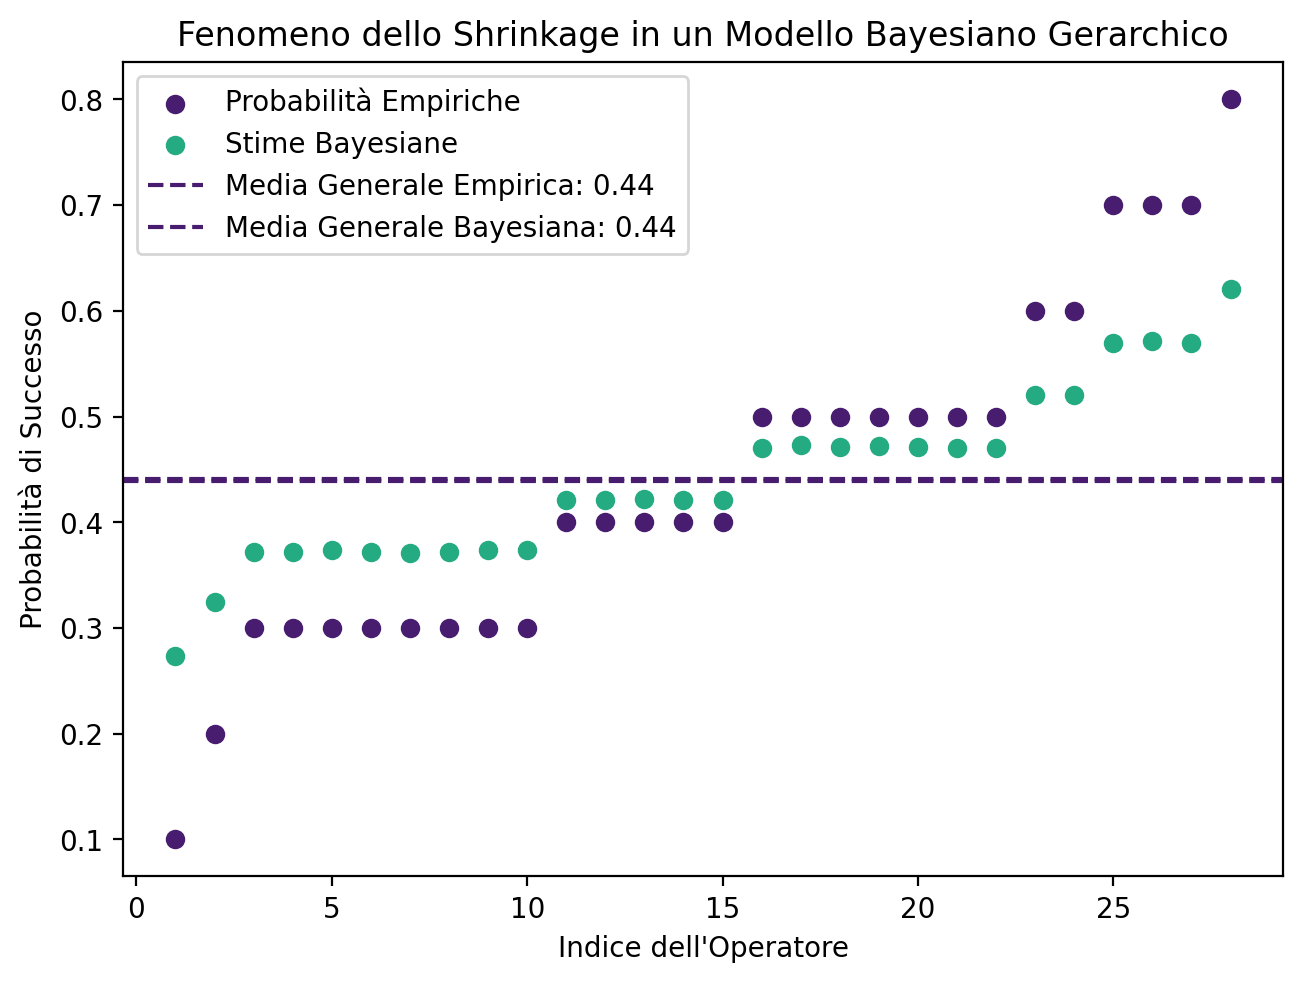

In [20]:
# Calcola la media generale delle probabilità empiriche
mean_empirical_prob = np.mean(empirical_probs)

# Calcola la media generale delle stime Bayesiane
mean_bayesian_estimate = np.mean(bayesian_estimates)

# Crea il grafico
plt.figure()

# Traccia le probabilità empiriche
plt.scatter(range(1, 29), empirical_probs, label='Probabilità Empiriche')

# Traccia le stime Bayesiane
plt.scatter(range(1, 29), bayesian_estimates, color="C2", label='Stime Bayesiane')

# Aggiungi linee orizzontali per indicare le medie generali
plt.axhline(y=mean_empirical_prob, linestyle='--', label=f'Media Generale Empirica: {mean_empirical_prob:.2f}')
plt.axhline(y=mean_bayesian_estimate, linestyle='--', label=f'Media Generale Bayesiana: {mean_bayesian_estimate:.2f}')

# Etichette e titolo
plt.xlabel('Indice dell\'Operatore')
plt.ylabel('Probabilità di Successo')
plt.title('Fenomeno dello Shrinkage in un Modello Bayesiano Gerarchico')
plt.legend()
plt.show()

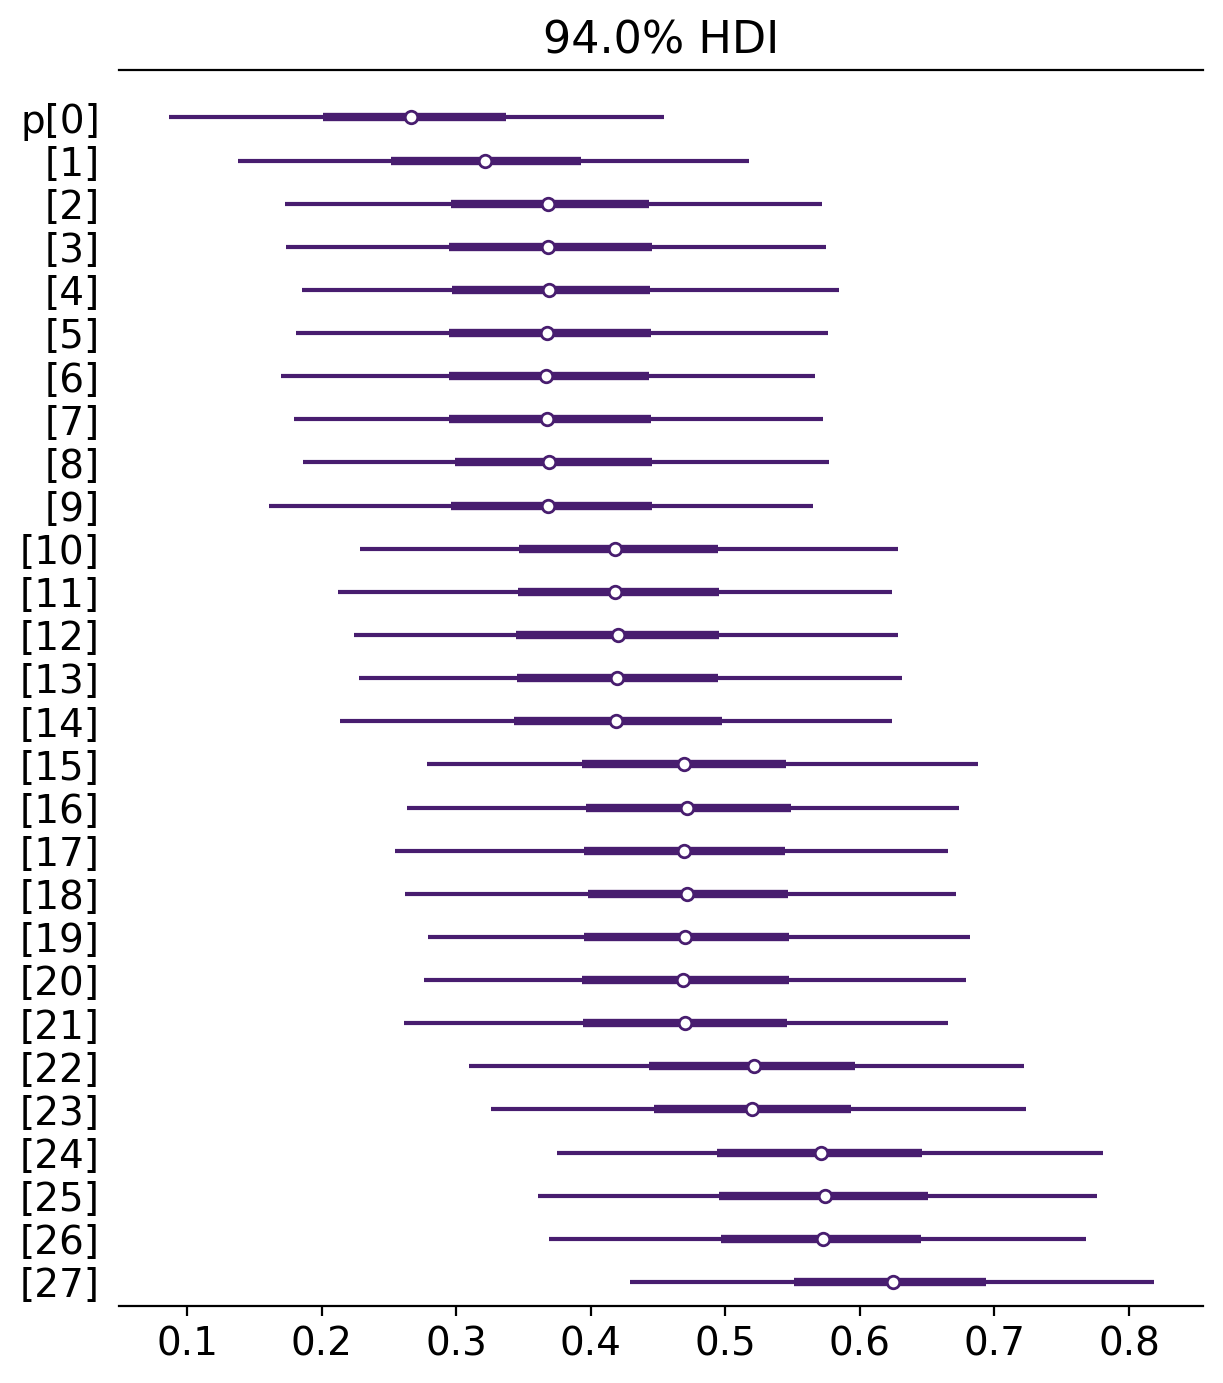

In [21]:
samples_p = trace.posterior["p"]
az.plot_forest(samples_p, combined=True, hdi_prob=0.94)
plt.show()

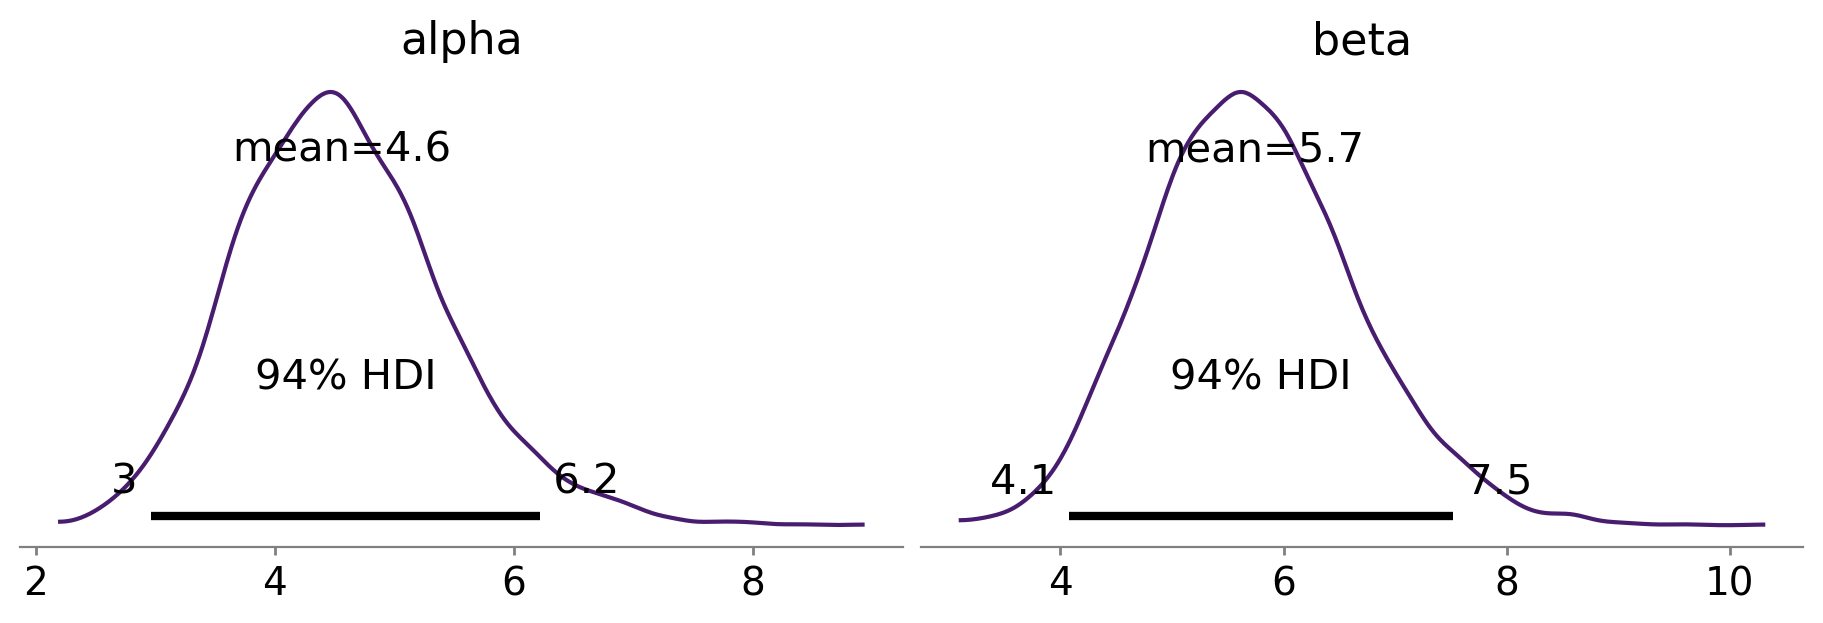

In [22]:
az.plot_posterior(trace, var_names=["alpha", "beta"], figsize=(9, 3))
plt.show()

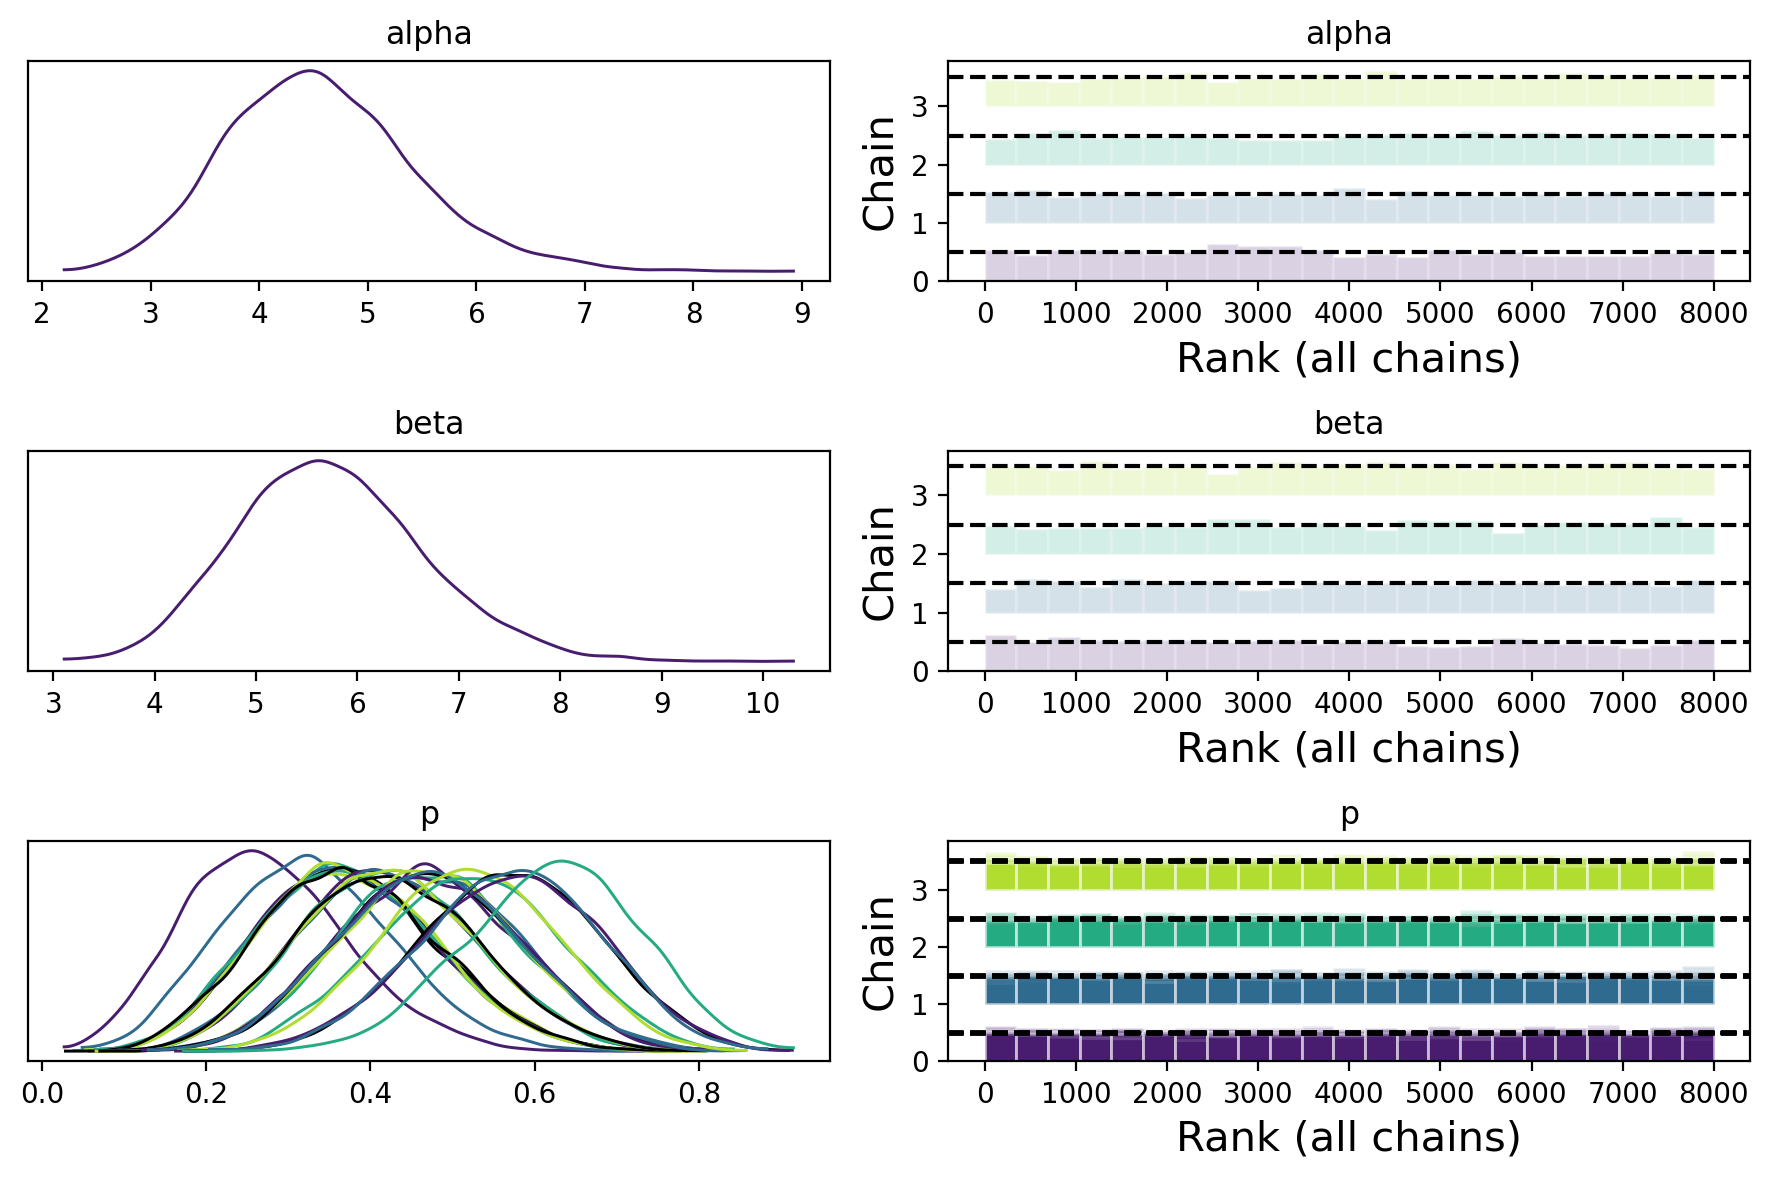

In [23]:
az.plot_trace(trace, combined=True, figsize=(9, 6), kind="rank_bars")
plt.tight_layout()
plt.show();

In [24]:
alphas = trace.posterior["alpha"]
betas = trace.posterior["beta"]

print(alphas)

<xarray.DataArray 'alpha' (chain: 4, draw: 2000)>
array([[5.23803147, 3.74156566, 3.91315292, ..., 3.79978312, 4.04484145,
        4.94877252],
       [3.34102457, 2.87975587, 2.62568218, ..., 5.29375072, 4.1289849 ,
        5.11469847],
       [3.98129218, 3.97005778, 5.93067424, ..., 4.86531395, 5.28026778,
        2.77107567],
       [4.00928944, 5.26127776, 3.58554431, ..., 5.28550297, 5.3044699 ,
        4.41755928]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999


In [25]:
# Function to calculate the mean of a Beta distribution
def beta_mean(alpha, beta):
    return alpha / (alpha + beta)

# Calculate the means for each pair of alpha and beta
sample_posterior_x_means = np.array([beta_mean(a, b) for a, b in zip(alphas, betas)])

In [26]:
sample_posterior_x_means.shape

(4, 2000)

In [27]:
sample_posterior_x_means

array([[0.47302681, 0.41515585, 0.40222349, ..., 0.39140872, 0.38949744,
        0.48261881],
       [0.3917823 , 0.45982923, 0.33838888, ..., 0.48610216, 0.46274292,
        0.44415804],
       [0.43209715, 0.43818438, 0.4140773 , ..., 0.43955671, 0.4553366 ,
        0.44023279],
       [0.40128654, 0.44589778, 0.41731576, ..., 0.51596878, 0.53589859,
        0.38053259]])

In [28]:
print(sample_posterior_x_means.mean())

0.4420500631597215


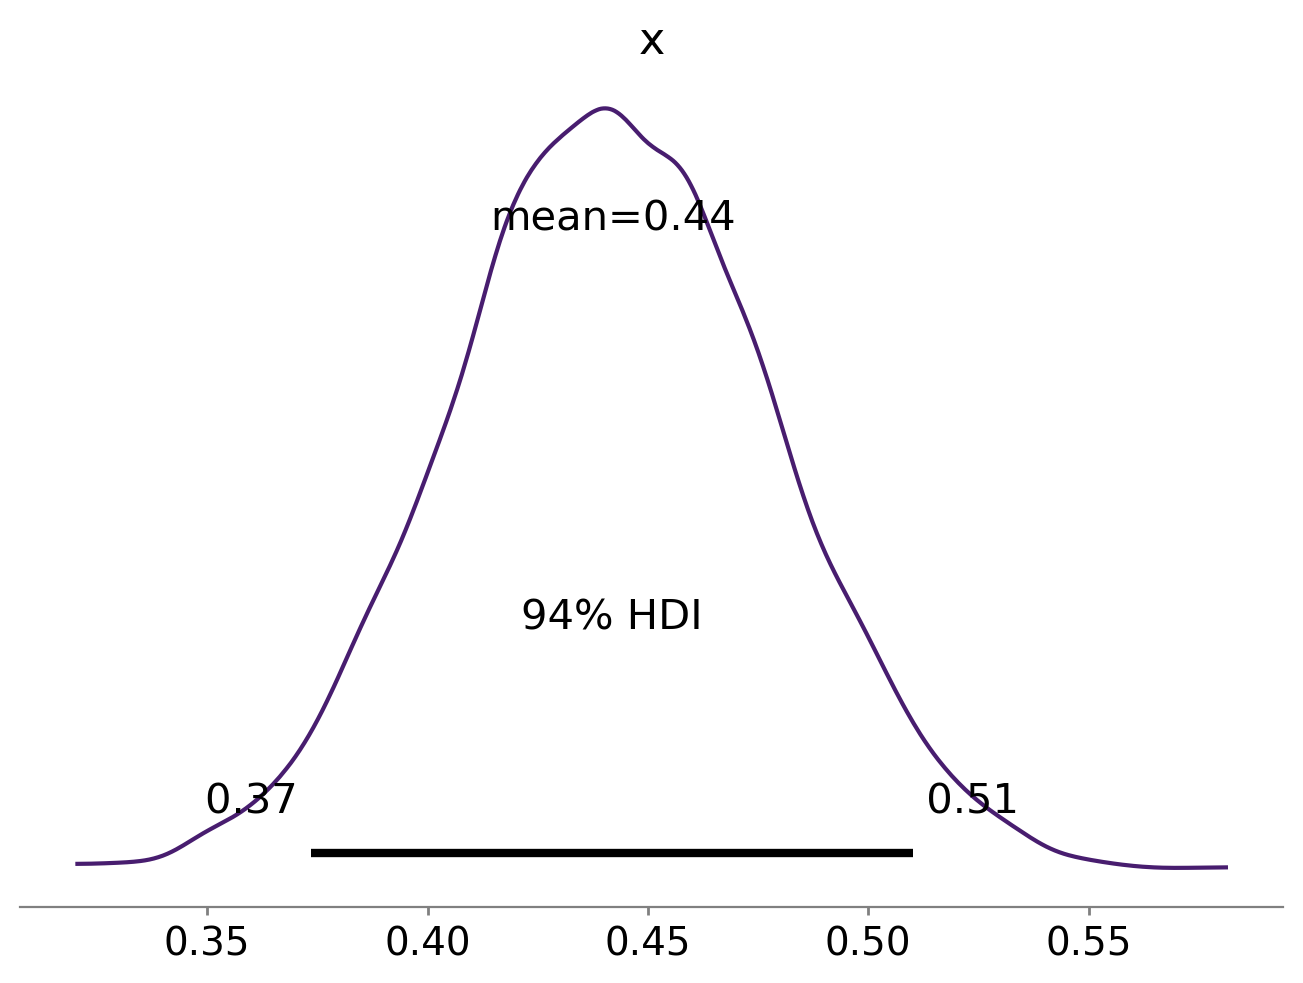

In [29]:
az.plot_posterior(sample_posterior_x_means)
plt.show()

In [30]:
df = pd.read_csv("../data/ash_25.csv")
df.head()

,subject_id,is_error
0,Subject_1,0
1,Subject_1,0
2,Subject_1,0
3,Subject_1,0
4,Subject_1,0


In [31]:
df["is_error"].mean()

0.43

In [32]:
# Group the data by 'subject_id' and sum the 'is_error' to get the number of errors for each subject
df_grouped = df.groupby('subject_id')['is_error'].sum().reset_index()

# Rename the column for clarity
df_grouped.rename(columns={'is_error': 'num_errors'}, inplace=True)
df_grouped

,subject_id,num_errors
0,Subject_1,0
1,Subject_10,4
2,Subject_11,5
3,Subject_12,5
4,Subject_13,6
5,Subject_14,6
6,Subject_15,6
7,Subject_16,6
8,Subject_17,8
9,Subject_18,8


In [33]:
# Definizione delle coordinate 
coords = {
    "subject": pd.Categorical(df_grouped['subject_id']).categories.tolist()
}

print(coords)

{'subject': ['Subject_1', 'Subject_10', 'Subject_11', 'Subject_12', 'Subject_13', 'Subject_14', 'Subject_15', 'Subject_16', 'Subject_17', 'Subject_18', 'Subject_19', 'Subject_2', 'Subject_20', 'Subject_21', 'Subject_22', 'Subject_23', 'Subject_24', 'Subject_25', 'Subject_3', 'Subject_4', 'Subject_5', 'Subject_6', 'Subject_7', 'Subject_8', 'Subject_9']}


In [34]:
ntrials = 12  # Numero di prove per ciascun soggetto

In [35]:
with pm.Model(coords=coords) as model_2:
    y_data = pm.ConstantData("y_data", df_grouped["num_errors"])
    n_trials = pm.ConstantData("n_trials", ntrials)
    
    # Iperparametri per la distribuzione a livello di gruppo
    alpha = pm.Gamma("alpha", 2, 0.5)
    beta = pm.Gamma("beta", 2, 0.5)
    
    # Probabilità specifiche per ciascun soggetto
    p = pm.Beta("p", alpha, beta, dims="subject")
    
    # Calcolo della probabilità media a livello di gruppo
    overall_p = pm.Deterministic("overall_p", alpha / (alpha + beta))
    
    # Verosimiglianza del modello
    Y_obs = pm.Binomial("Y_obs", n=n_trials, p=p, observed=y_data, dims="subject")

In [36]:
with model_2:
    idata_2 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:12.238146
Sampling...


  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                            | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                              | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                                           | 0/2000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                                                           | 0/2000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                                                           | 0/2000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                                                           | 0/2000 [00:02<?, ?it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 933.55it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 933.96it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 934.58it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 935.10it/s]

Sampling time =  0:00:02.299413
Transforming variables...
Transformation time =  0:00:00.082469


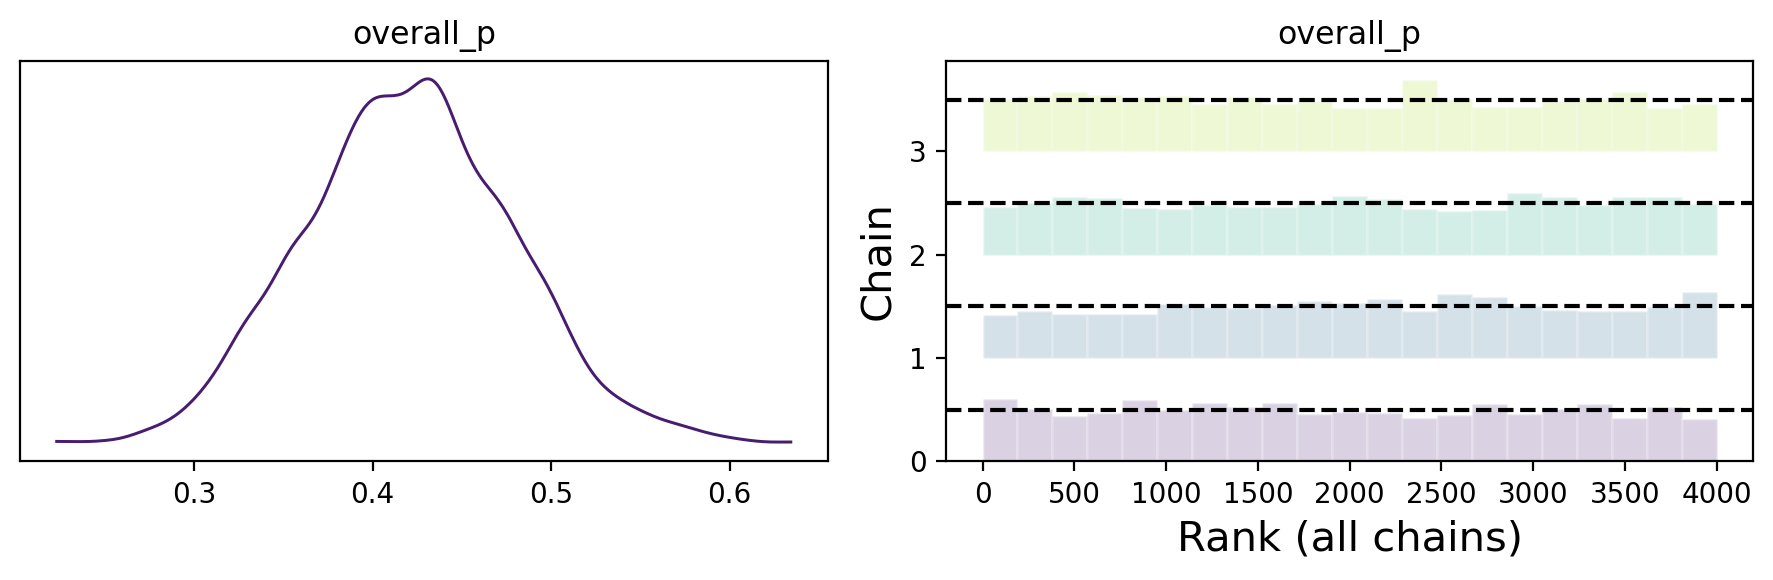

In [37]:
var_names = ["overall_p"]
az.plot_trace(
    idata_2, combined=True, var_names=var_names, kind="rank_bars", figsize=(9, 3)
)
plt.tight_layout()
plt.show();

In [38]:
az.summary(idata_2, "overall_p")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
overall_p,0.42,0.059,0.302,0.52,0.001,0.001,3639.0,2992.0,1.0


In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Sep 22 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.13.1

matplotlib: 3.8.0
numpy     : 1.25.2
arviz     : 0.16.1
scipy     : 1.11.2
pymc      : 5.8.2
pandas    : 2.1.1
requests  : 2.31.0

Watermark: 2.4.3

